In [54]:
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D

from libs.utils import *
from libs.generate_boxes import  *

In [55]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [56]:
class StateCNN(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size):
        super(StateCNN, self).__init__()
        
        self.case_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                               padding='valid', input_shape = selected_size)
        self.case_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                               padding='valid')
        
        self.select_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                  padding='valid', input_shape=selected_size)
        self.select_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                 padding='valid')
        
        self.remain_cnn1 = Conv1D(filters=32, kernel_size=2, activation='relu',
                                 padding='same', input_shape = remain_size)
        self.remain_cnn2 = Conv1D(filters=32, kernel_size=2, activation='relu',
                                 padding='same')
    
    def call(self, cb_list):
        c,s,r = cb_list[0], cb_list[1], cb_list[2]
        
        c = self.case_cnn1(c)
        c = MaxPooling2D(pool_size=(2,2))(c)
        c = self.case_cnn2(c)
        c = MaxPooling2D(pool_size=(2,2))(c)
        c = Flatten()(c)
        
        s = self.select_cnn1(s)
        s = MaxPooling2D(pool_size=(2,2))(s)
        s = self.select_cnn2(s)
        s = MaxPooling2D(pool_size=(2,2))(s)
        s = Flatten()(s)
        
        r = self.remain_cnn1(r)
        r = self.remain_cnn2(r)
        r = MaxPooling1D(pool_size=1)(r)
        r = Flatten()(r)
        
        x = concatenate([c,s,r])
        return x

In [57]:
class Actor(tf.keras.Model):
    def __init__(self, output_size):
        super(Actor, self).__init__()
        self.d1 = Dense(2048, activation='relu')
        self.d2 = Dense(1024, activation='relu')
        self.actor = Dense(output_size)
        
    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        actor = self.actor(x)
        return actor

In [58]:
class Critic(tf.keras.Model):
    def __init__(self, output_size):
        super(Critic, self).__init__()
        self.d1 = Dense(2048, activation='relu')
        self.d2 = Dense(1024, activation='relu')
        self.critic = Dense(output_size)
        
    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        critic = self.critic(x)
        return critic

In [59]:
class ActorCriticAgent:
    def __init__(self, L=20, B=20, H=20, n_remains=5, lr=1e-8, gamma=0.99):
        
        self.state_size = (L,B,1)
        self.selected_size = (L,B,H)
        self.remain_size = (n_remains, 3)
        self.output_size = 1
        
        self.lr = lr
        self.gamma = gamma
        
        self.state_cnn = StateCNN(self.state_size, self.selected_size, self.remain_size)
        self.actor = Actor(self.output_size)
        self.critic = Critic(self.output_size)
        
        self.actor_optimizer = Adam(learning_rate=self.lr)
        self.critic_optimizer = Adam(learning_rate=self.lr)
        
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def get_action(self, state, s_locs, r_boxes):
        sc = self.state_cnn([state, s_locs, r_boxes])
        actor = self.actor(sc)
        argmax_idx = np.where(actor == tf.math.reduce_max(actor))
        action_idx = argmax_idx[0][0]
        return action_idx
    
    def actor_loss():
        pass
        
    def critic_loss():
        pass
        
    def train():
        state_params = self.
        actor_params = self.
        critic_params = self.
        
        for 
            with tf.GradientTape() as tape:
                state_cnn = self.state_cnn([state, s_boxes, remains])
                actor = self.actor()
                values = self.critic()
                next_values = self.critic()
                
                expect_reward = 
                
                actor_loss = 
                critic_loss = 
                
                self.avg_actor_loss += 
                self.avg_critic_loss += 
            
            actor_grads = actor_tape.gradient(actor_loss, actor_params)
            critic_grads = critic_tape.gradient(critic_loss, critic_params)

In [60]:
max_episode = 2000
N_MDD = 5
K = 3
N_Candidates = 4

In [61]:
boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20,]],min_s = 1,
                                       N_mdd = N_MDD)
boxes = boxes[0]
gt_pos = gt_pos[0]

num_max_boxes = len(boxes)
num_max_remain = num_max_boxes - K

num_max_boxes, num_max_remain

(5, 2)

In [62]:
env = Bpp3DEnv()
agent = ActorCriticAgent(L=20, B=20, H=20, n_remains=num_max_remain, 
                         lr=1e-6, gamma=0.99)

In [79]:
frac_l, avg_actor_loss, avg_critic_loss = [],[],[]
for episode in range(max_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    used_boxes, pred_pos = [], []
    r_boxes = np.array(np.array(boxes).copy())
    
    while not done:
        state = env.container.copy()
        k = min(K, len(r_boxes))
        step += 1
        
        selected = cbn_select_boxes(r_boxes[:N_Candidates], k)
        s_order = get_selected_order(selected, k)
        
        state_h = env.update_h().copy()
        in_state, in_r_boxes = raw_to_input(state_h, s_order, r_boxes, num_max_remain)
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c , num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)
        
        action_idx = agent.get_action(in_state, s_loc_c, in_r_boxes)
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
            
            used_boxes = used_boxes_c[action_idx]
            pred_pos = pred_pos_c[action_idx]
            
            env.convert_state(next_cube_c[action_idx])
            
            if len(r_boxes) == 0:
                done = True
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            if len(r_boxes) == 0:
                done = True
        
        if done:
            avg_frac = 0 if len(frac_l) == 0 else np.mean(frac_l)
            frac_l.append(env.terminal_reward())
            
            agent.train_model()
            
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
            
    log = "=====episode: {:5d} | ".format(e)
    log += "env.terminal_reward(): {:.3f} | ".format(env.terminal_reward())
    log += "actor avg loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "critic avg loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

KeyboardInterrupt: 

In [63]:
env.reset()
done = False
step = 0

r_boxes = np.array(np.array(boxes).copy())
state = env.container.copy()
k = min(K, len(r_boxes))
step += 1

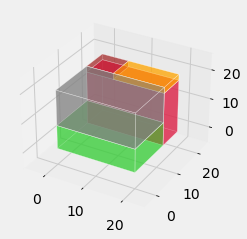

In [64]:
vis_box(boxes, gt_pos)

In [65]:
selected = cbn_select_boxes(r_boxes[:N_Candidates], k)
selected

array([[[20,  7, 18],
        [20, 13,  8],
        [ 7,  7,  2]],

       [[20,  7, 18],
        [20, 13,  8],
        [20, 13, 12]],

       [[20,  7, 18],
        [20, 13, 12],
        [ 7,  7,  2]],

       [[20, 13,  8],
        [20, 13, 12],
        [ 7,  7,  2]]])

In [66]:
s_order = get_selected_order(selected, k)
s_order

array([[[ 7,  7,  2],
        [20,  7, 18],
        [20, 13,  8]],

       [[ 7,  7,  2],
        [20,  7, 18],
        [20, 13, 12]],

       [[ 7,  7,  2],
        [20, 13,  8],
        [20,  7, 18]],

       [[ 7,  7,  2],
        [20, 13,  8],
        [20, 13, 12]],

       [[ 7,  7,  2],
        [20, 13, 12],
        [20,  7, 18]],

       [[ 7,  7,  2],
        [20, 13, 12],
        [20, 13,  8]],

       [[20,  7, 18],
        [ 7,  7,  2],
        [20, 13,  8]],

       [[20,  7, 18],
        [ 7,  7,  2],
        [20, 13, 12]],

       [[20,  7, 18],
        [20, 13,  8],
        [ 7,  7,  2]],

       [[20,  7, 18],
        [20, 13,  8],
        [20, 13, 12]],

       [[20,  7, 18],
        [20, 13, 12],
        [ 7,  7,  2]],

       [[20,  7, 18],
        [20, 13, 12],
        [20, 13,  8]],

       [[20, 13,  8],
        [ 7,  7,  2],
        [20,  7, 18]],

       [[20, 13,  8],
        [ 7,  7,  2],
        [20, 13, 12]],

       [[20, 13,  8],
        [20,  7, 18],
    

In [67]:
state_h = env.update_h().copy()
in_state, in_r_boxes = raw_to_input(state_h, s_order, r_boxes, num_max_remain)

In [68]:
pred_pos, used_boxes = [], []

In [69]:
s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)

In [70]:
action_idx = agent.get_action(in_state, s_loc_c, in_r_boxes)
action_idx

20

In [71]:
num_loaded_box_c

[2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [72]:
num_loaded_box = num_loaded_box_c[action_idx]
num_loaded_box

3

In [73]:
new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
new_used_boxes

[array([20, 13, 12]), array([20,  7, 18]), array([7, 7, 2])]

In [74]:
r_boxes

array([[20,  7, 18],
       [20, 13,  8],
       [20, 13, 12],
       [ 7,  7,  2],
       [13,  7,  2]])

In [75]:
r_boxes = get_remain(new_used_boxes, r_boxes)
r_boxes

array([[20, 13,  8],
       [13,  7,  2]])

In [76]:
used_boxes = used_boxes_c[action_idx]
pred_pos = pred_pos_c[action_idx]

In [77]:
env.convert_state(next_cube_c[action_idx])
t_state = env.container.copy()
t_state_h = env.container_h.copy()

In [ ]:
k = min